
<h3 style="text-align: center;">Hello! Welcome to my Notebook


### Importing Libraries

In [2]:
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 


import tensorflow as tf
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Input,Dense
from tensorflow.keras.callbacks import EarlyStopping

### Displaying Sample Images

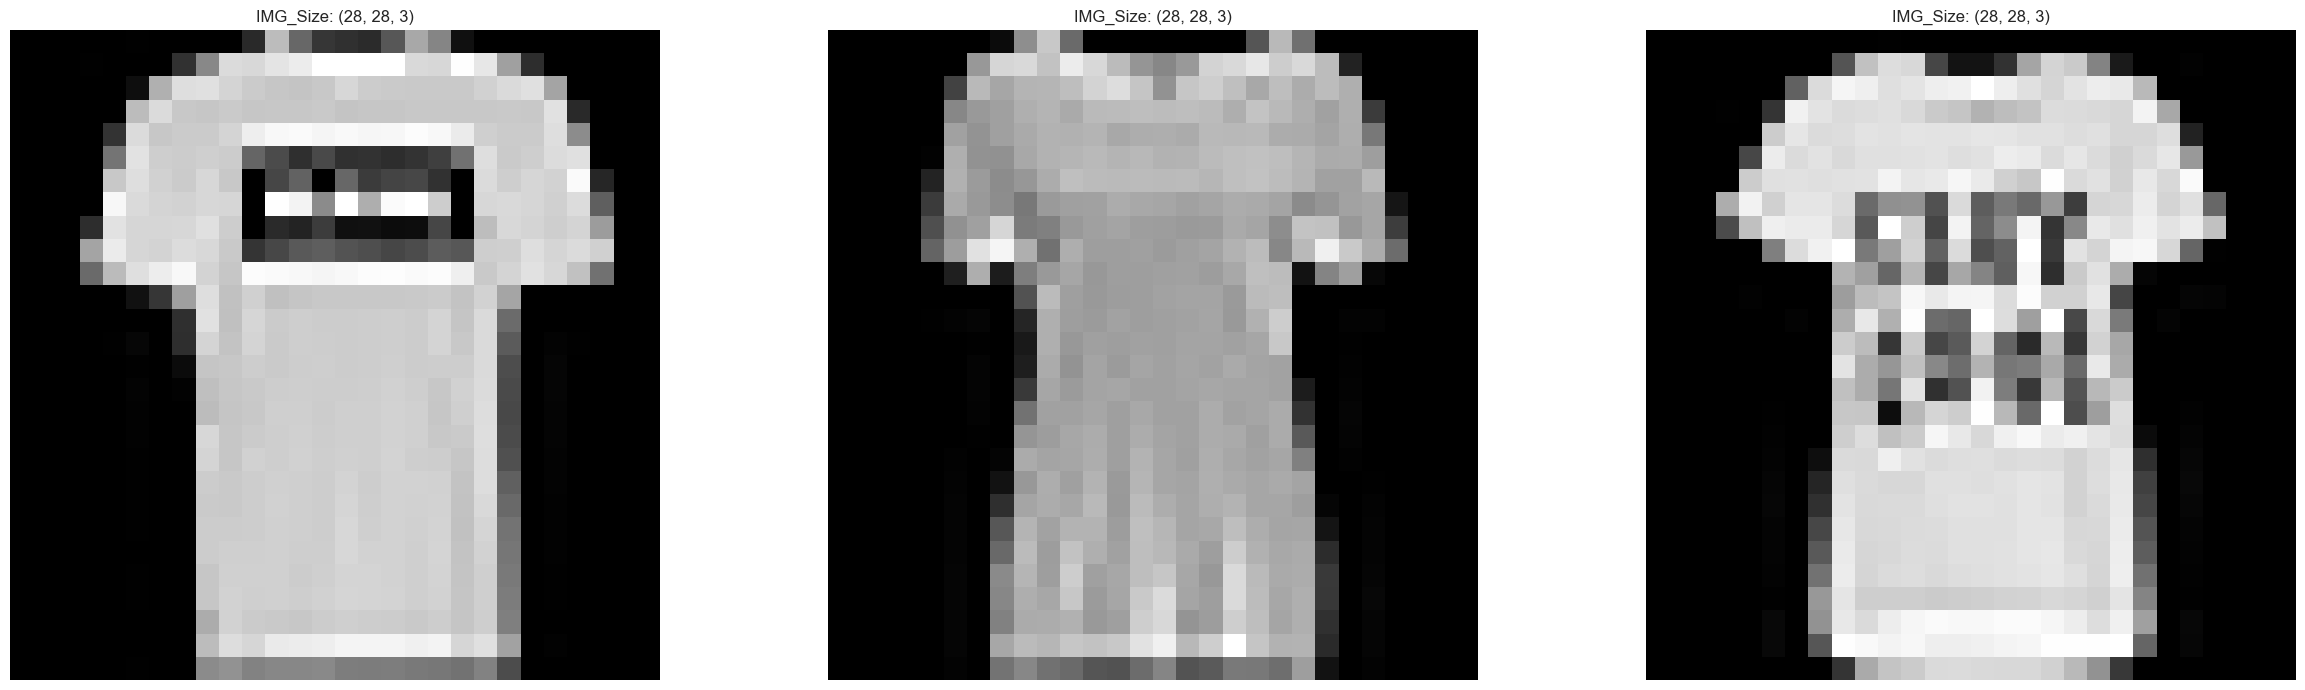

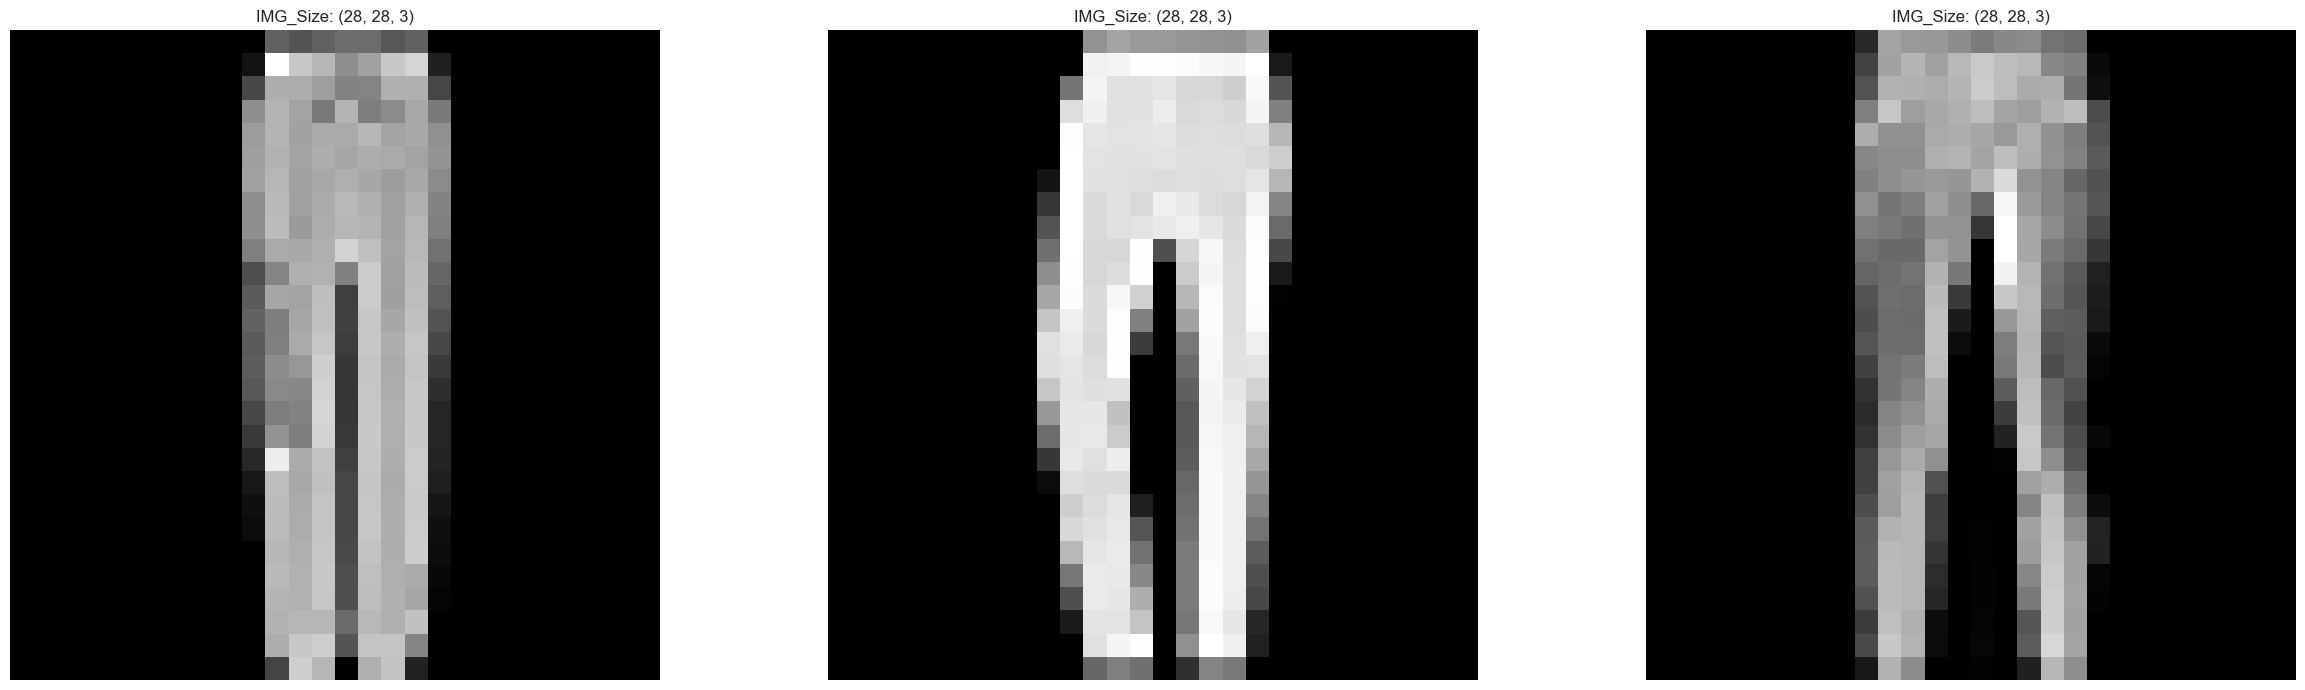

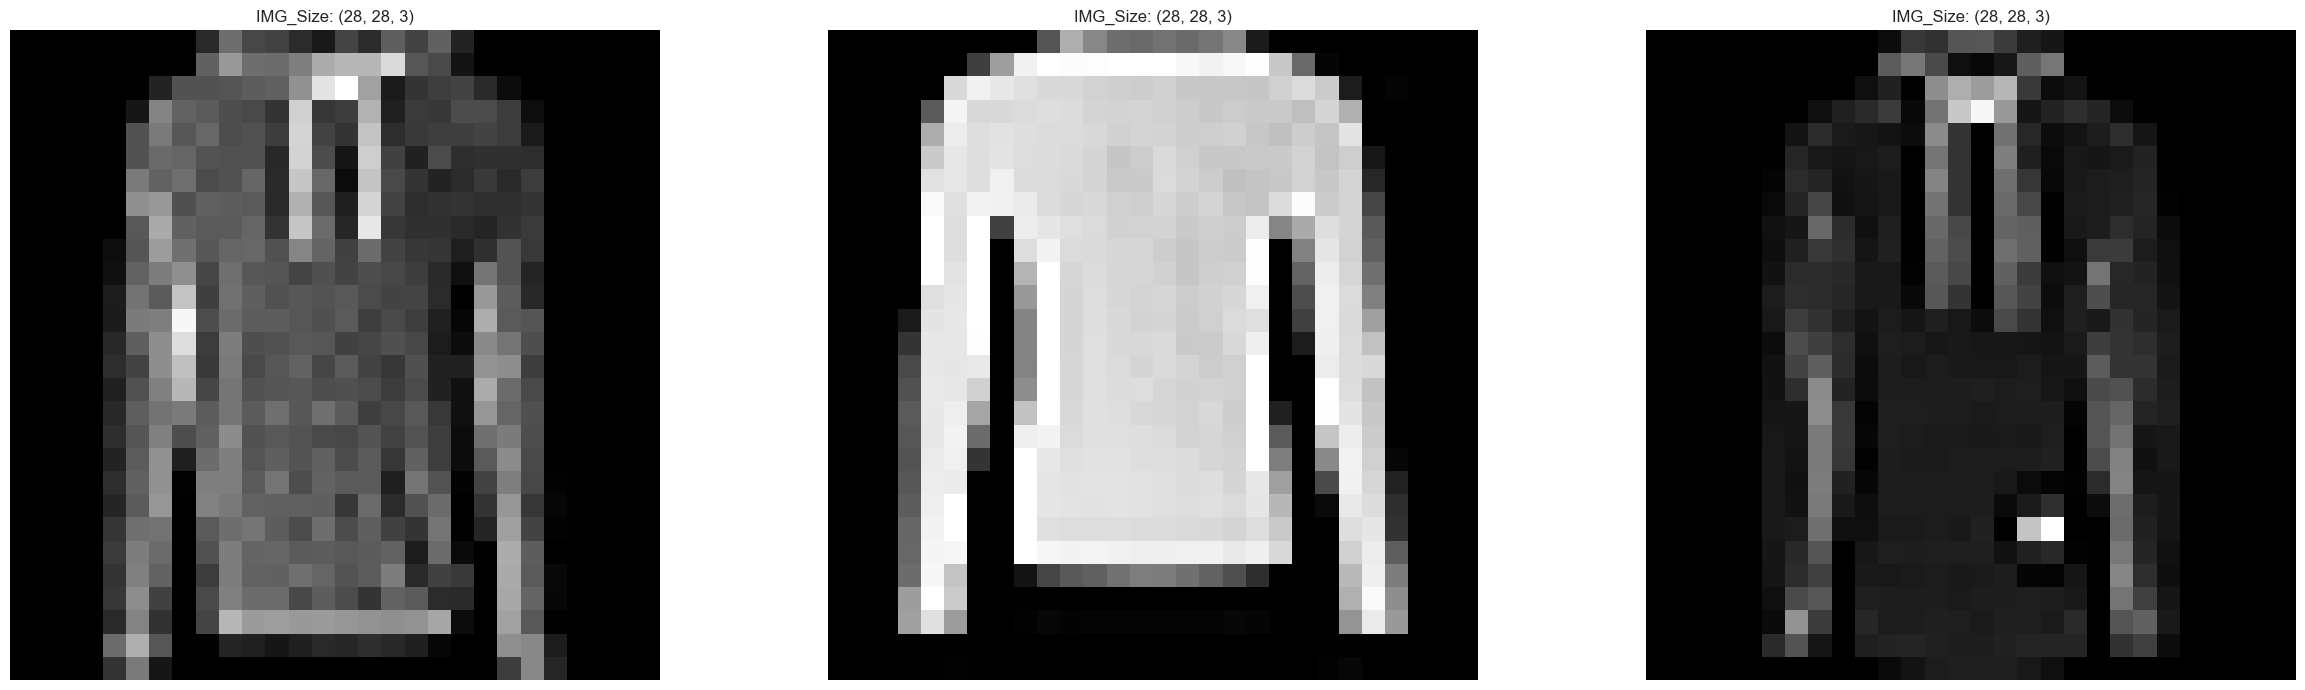

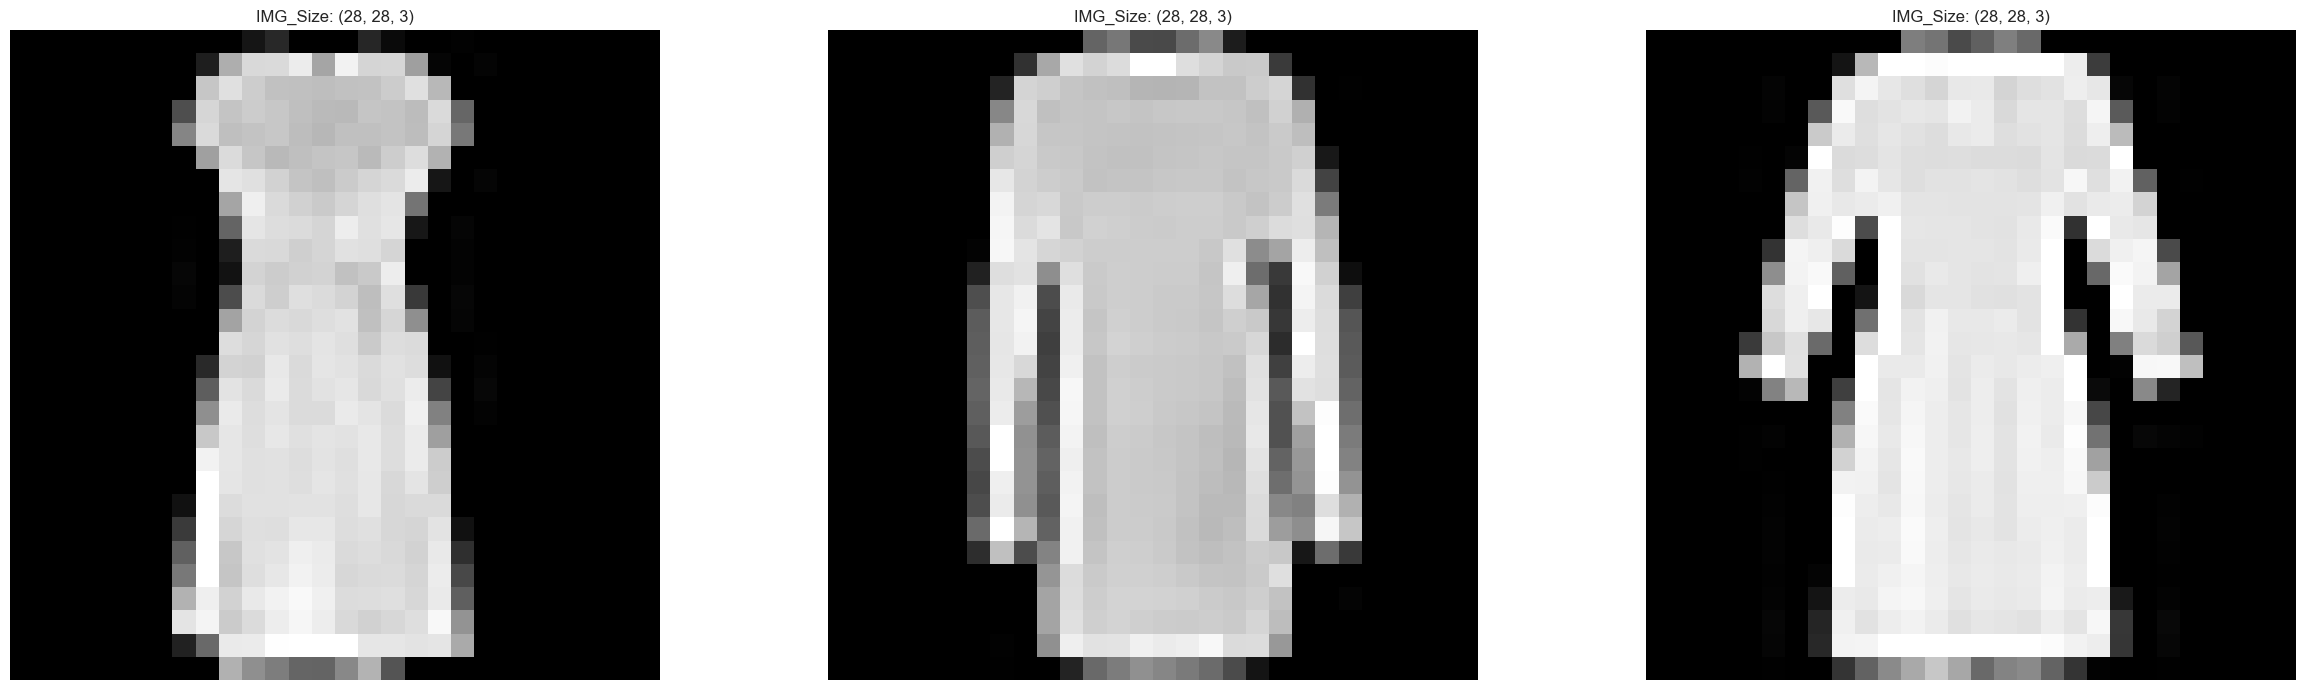

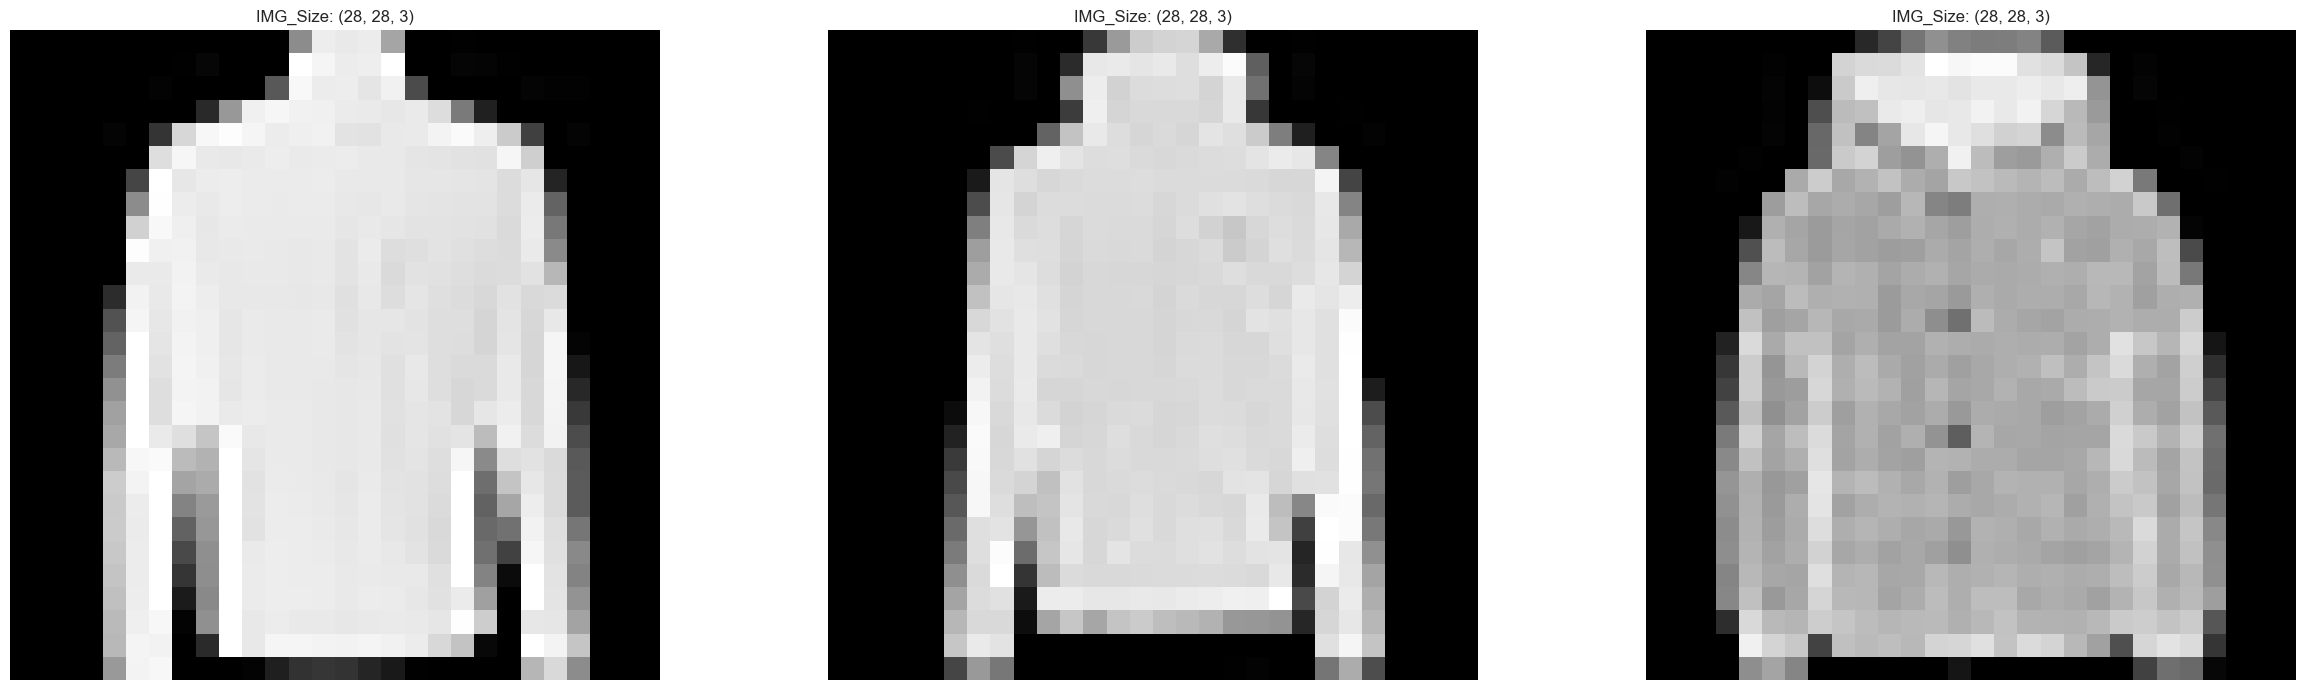

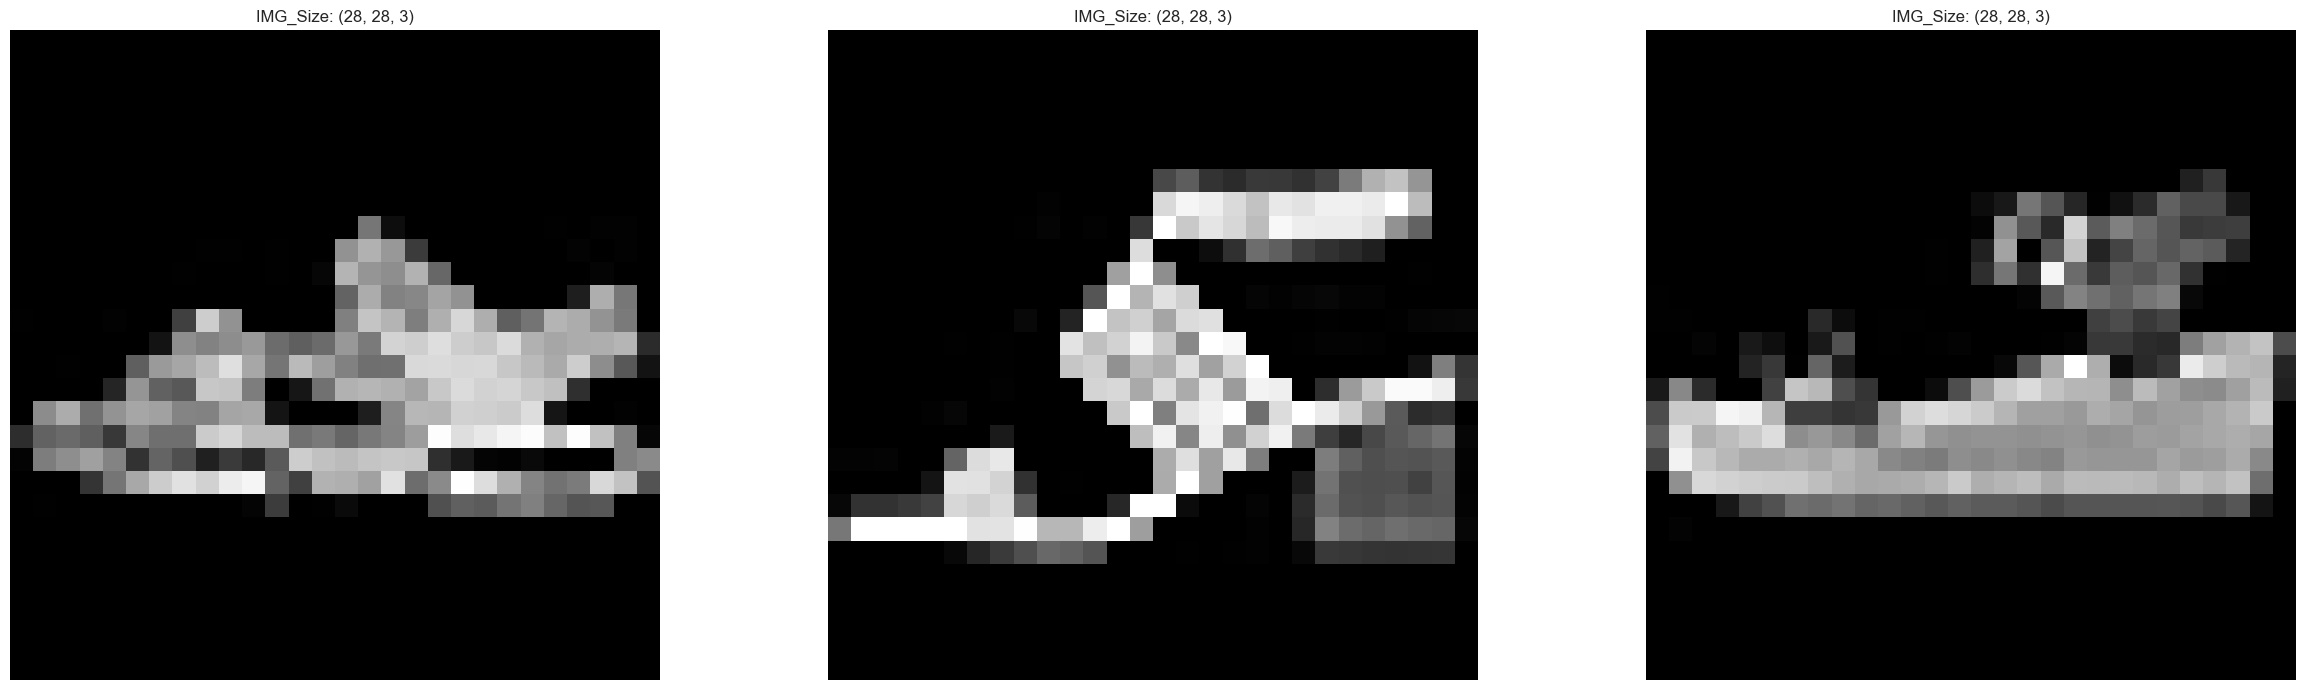

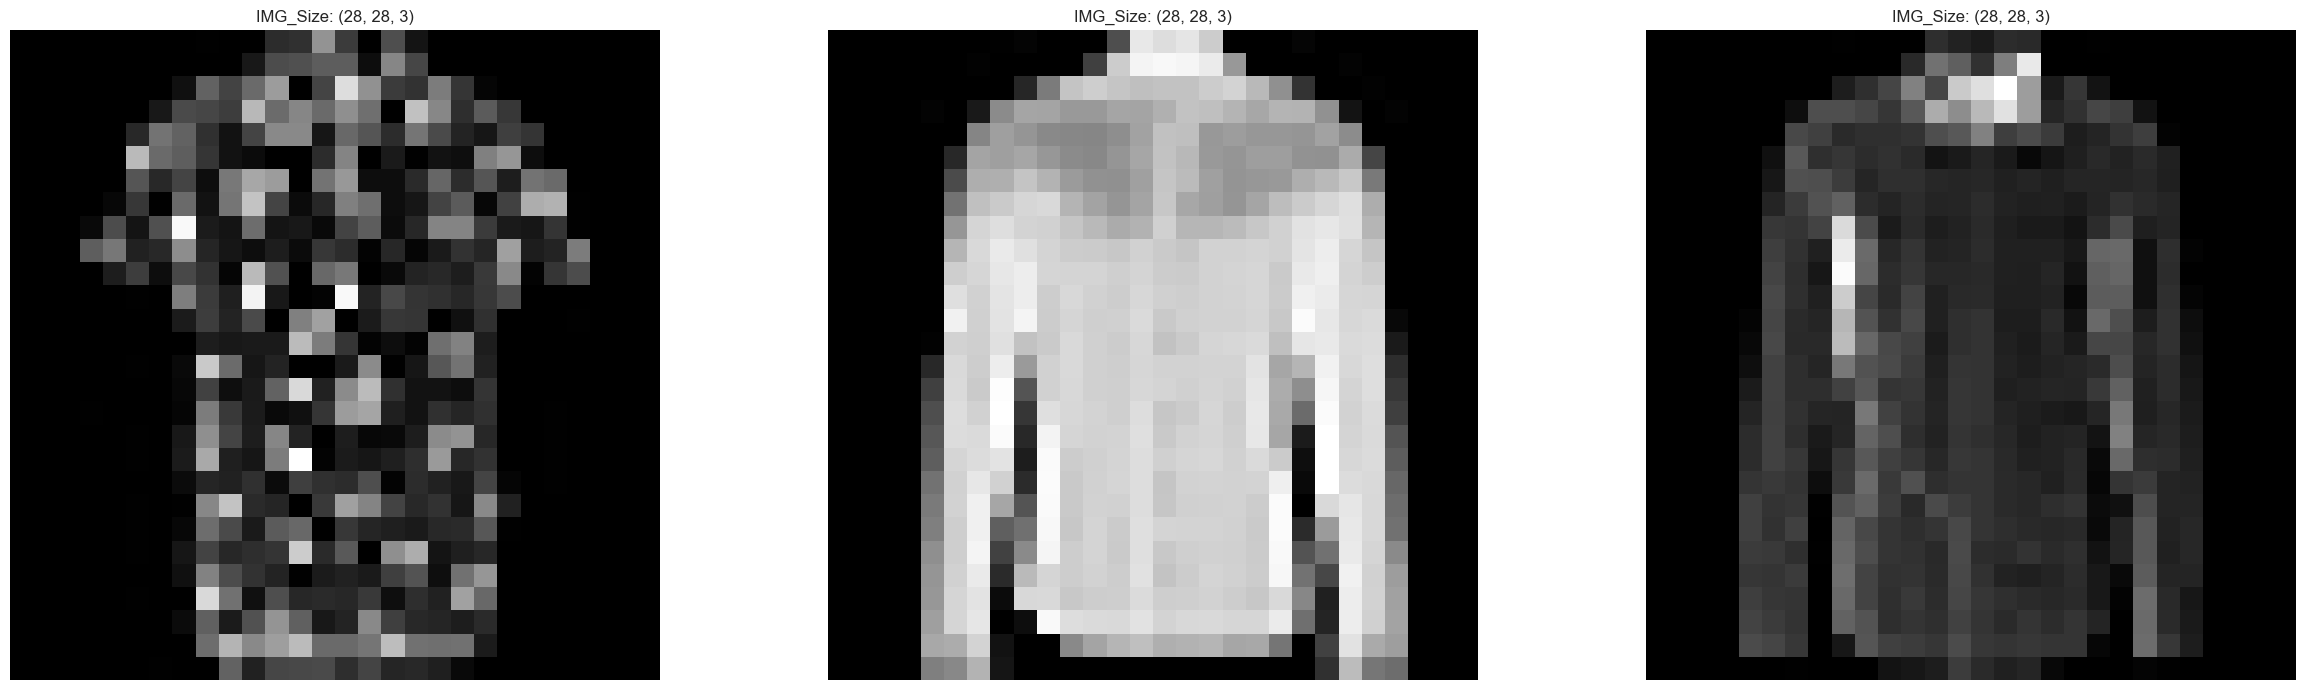

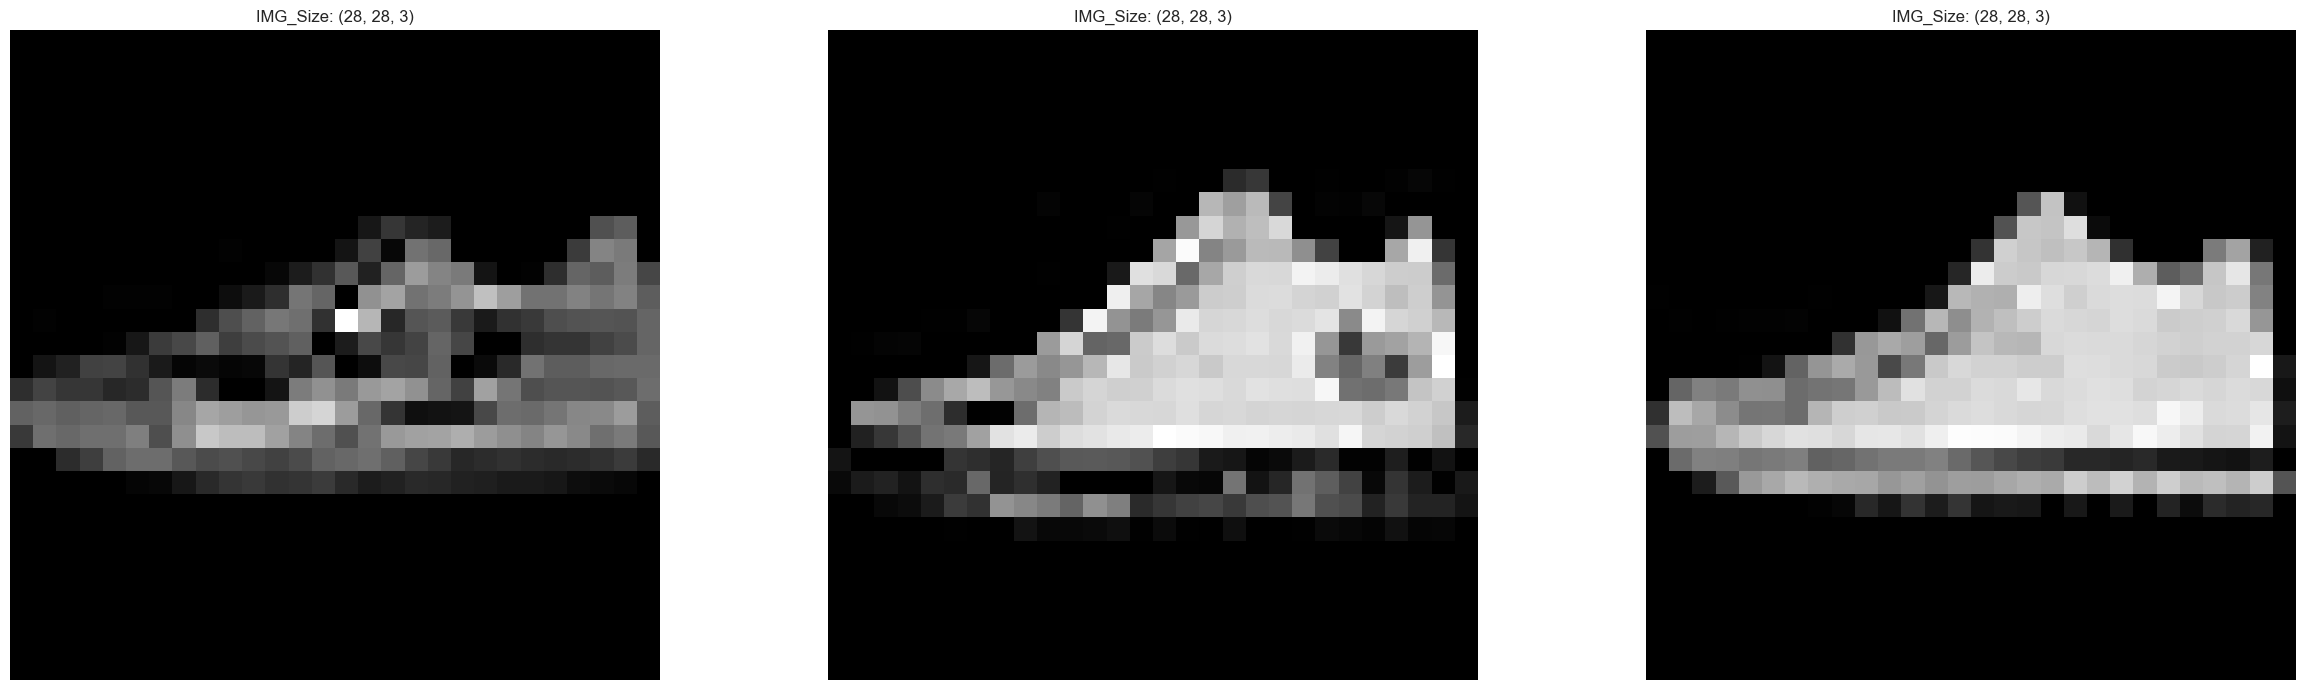

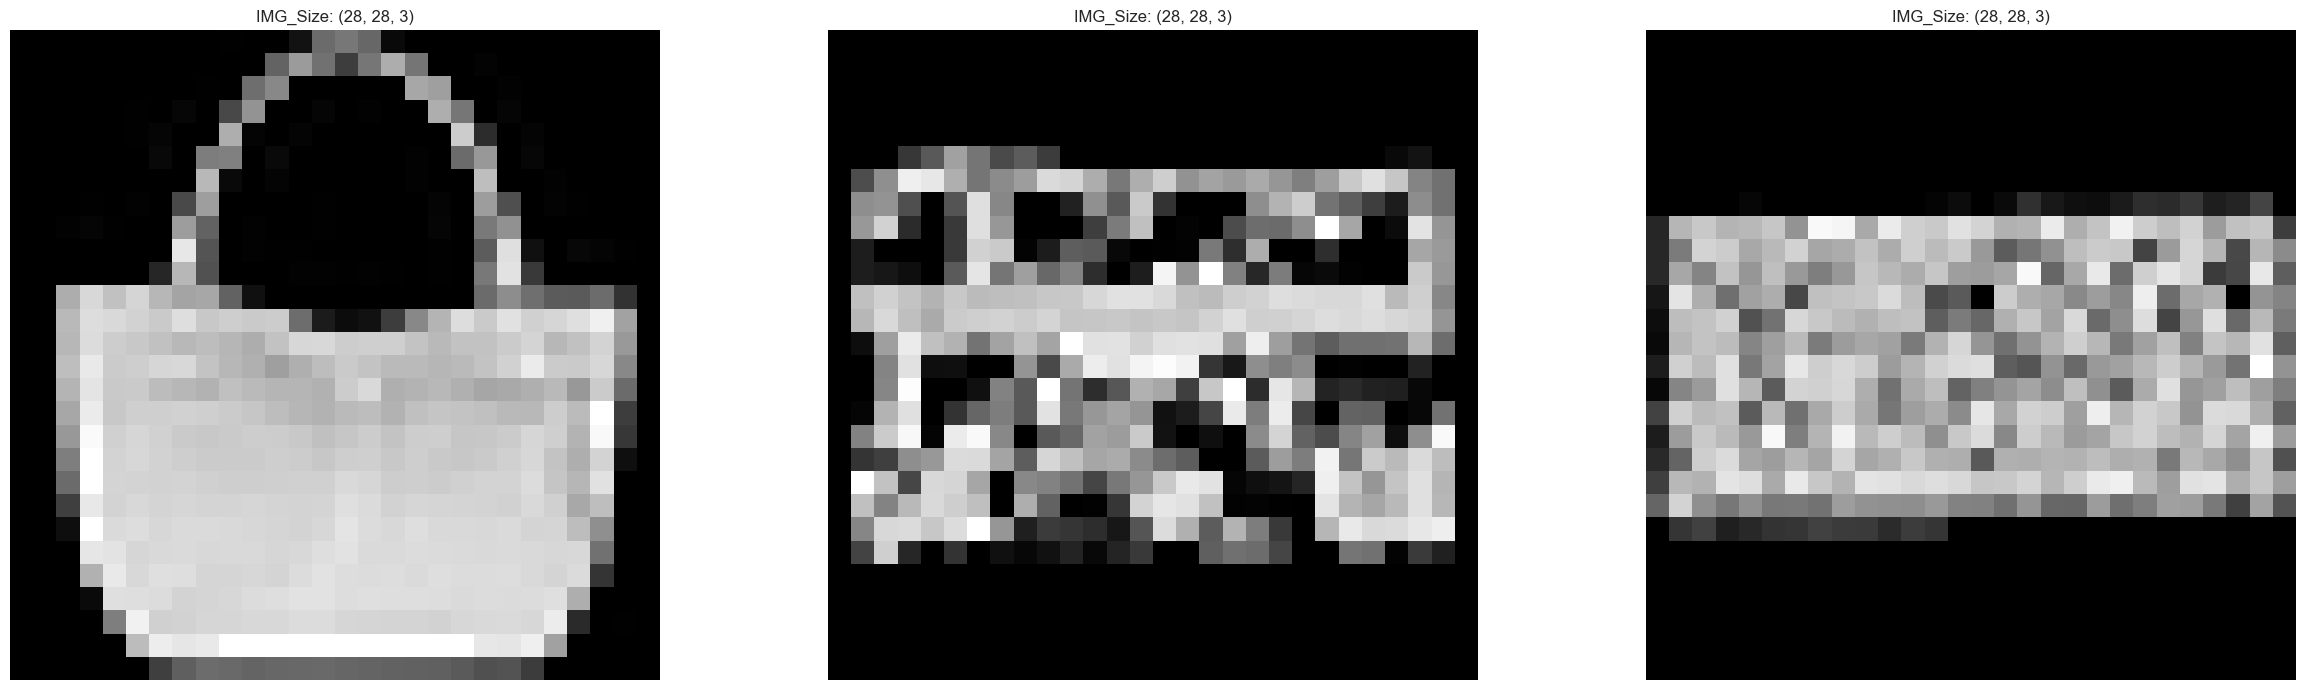

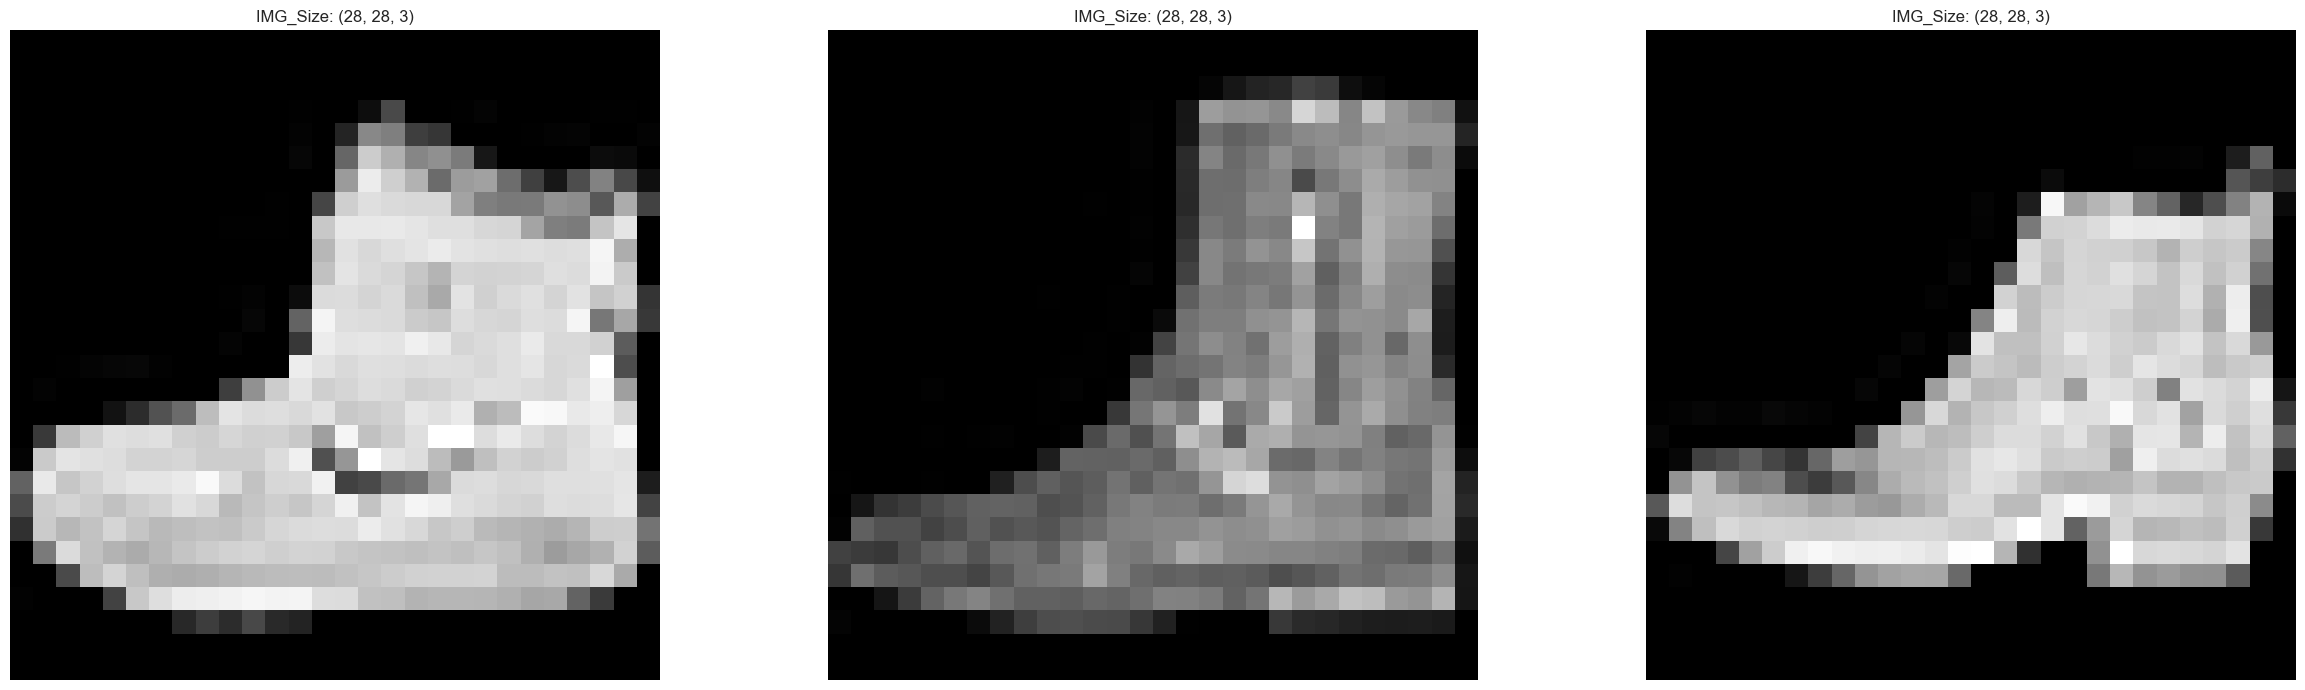

In [3]:
train_folder= 'train'
test_folder= 'test'

files = ['0', '1','2','3','4','5','6','7','8','9']

def Display_IMAGES(folder):
    for file in files:
        path = os.path.join(folder, file)
        fig, axes = plt.subplots(1, 3, figsize=(25, 7)) 
        for i, img in enumerate(os.listdir(path)[:3]): 
            img_array = cv2.imread(os.path.join(path, img))
            
            # Display the image with size in the title
            img_shape = img_array.shape
            axes[i].imshow(img_array)
            axes[i].set_title(f"IMG_Size: {img_shape}")
            axes[i].axis('off')
            
        plt.tight_layout()
    
    plt.show()

Display_IMAGES(train_folder)


> * Nearly all images are uniformly sized at **(28×28)** with **3** color channels.
> * To improve the quality for processing, I will resize them to **(64×64)**. While this won't enhance the original resolution, it will provide a larger canvas **for better feature extraction during model training**.



### Image Data Preparation: Reading and Resizing Images


In [4]:
IMAGE_SIZE =  (64,64)

#📌 TRAIN DATA
print('Training Images:')
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32
)



#📌 TEST DATA
print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_folder, 
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32
)

Training Images:
Found 60000 files belonging to 10 classes.
Testing Images:
Found 10000 files belonging to 10 classes.


### Visualize Sample Images from the Dataset (After Resizing )

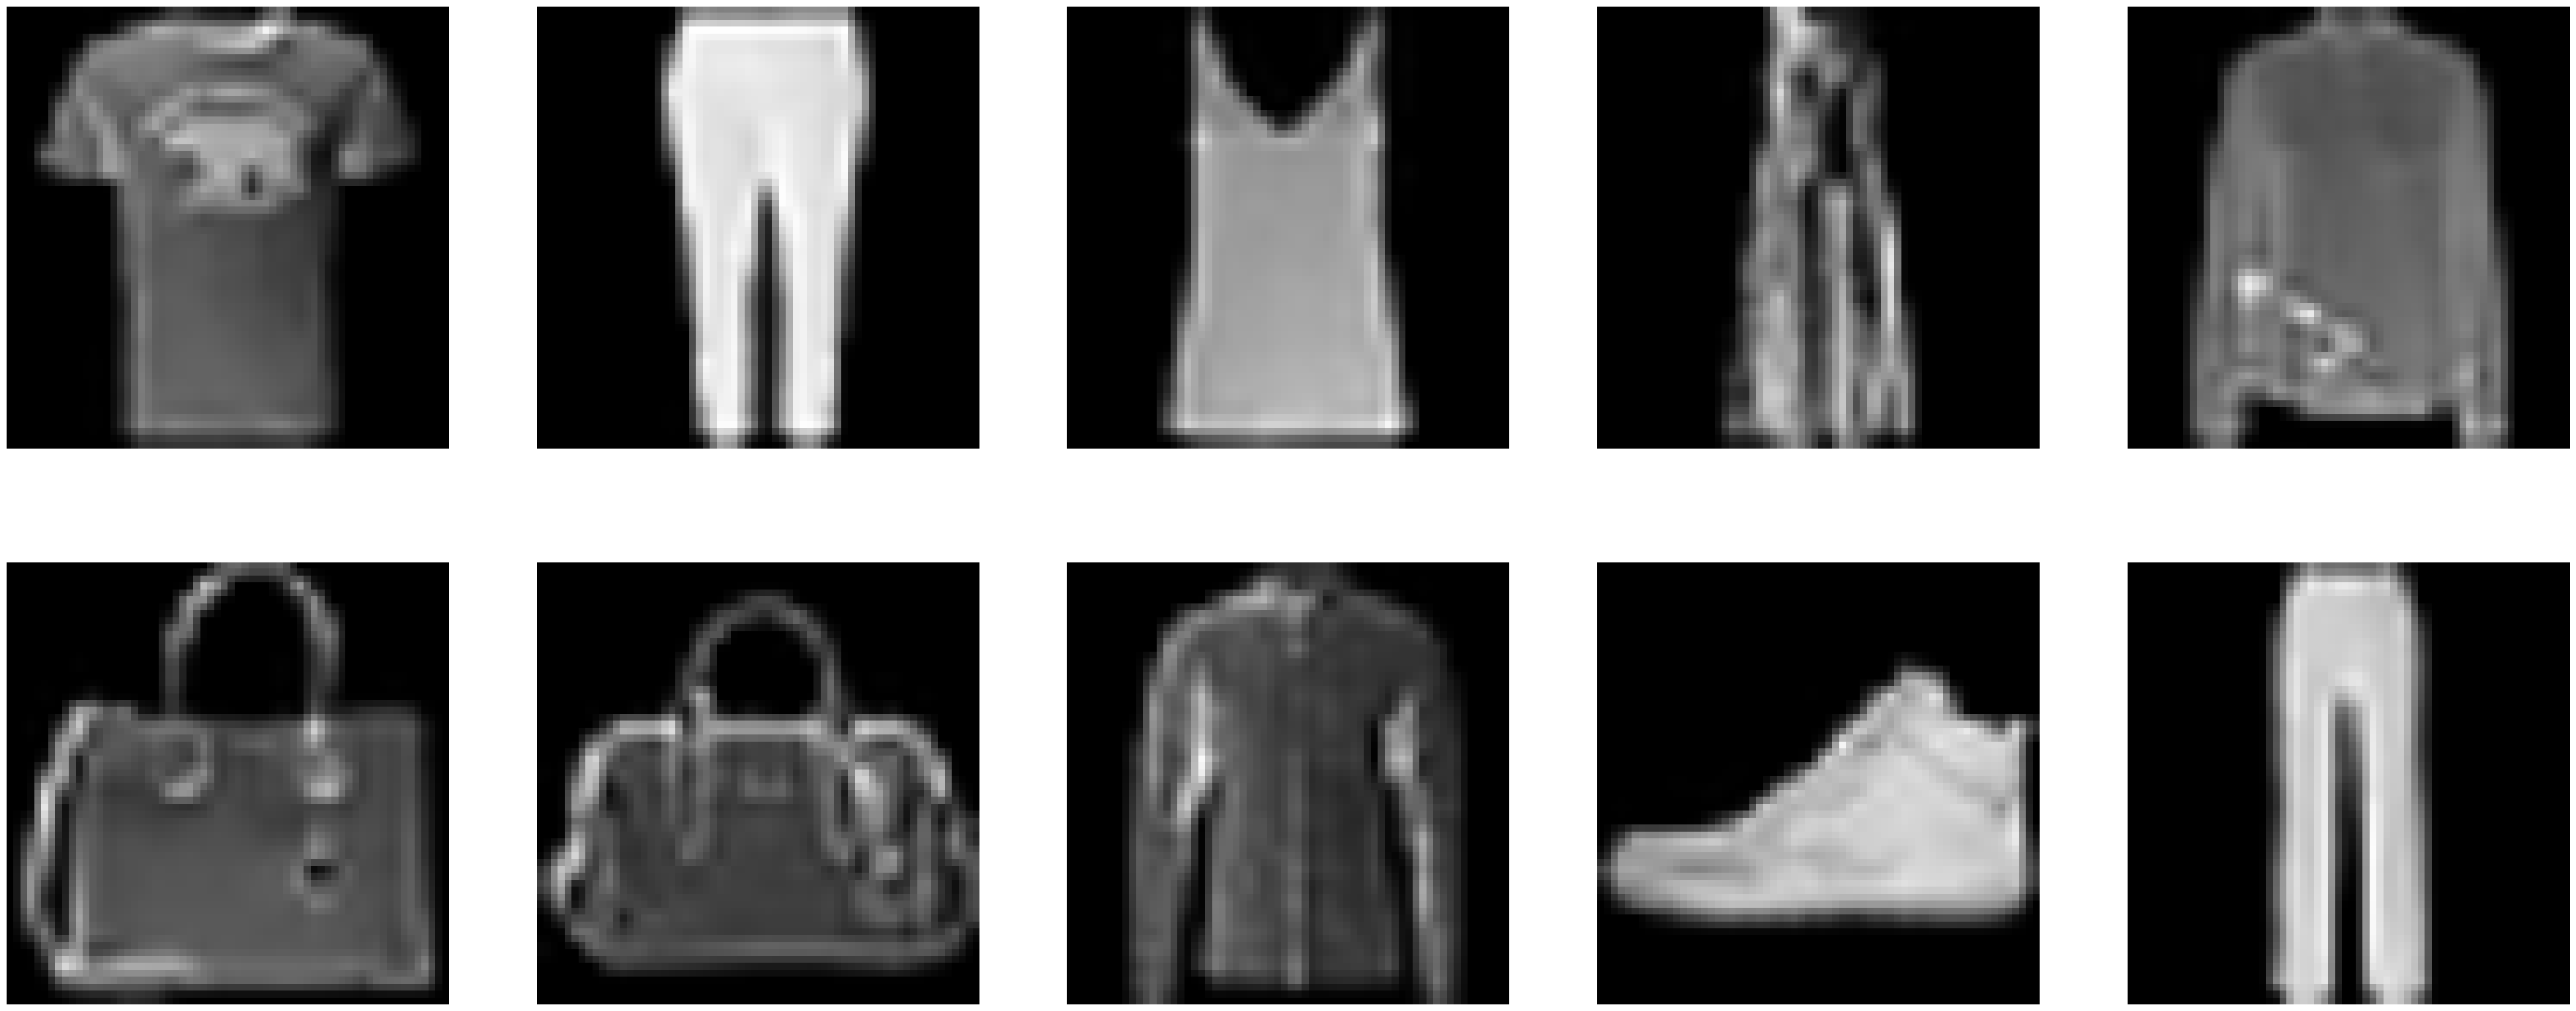

In [5]:
def plot_images(dataset, num_images=10):
    plt.figure(figsize=(50, 20))
    for images, _ in dataset.take(1):
        for i in range(num_images):
            plt.subplot(2, 5, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis('off')
    plt.show()

plot_images(train_ds)

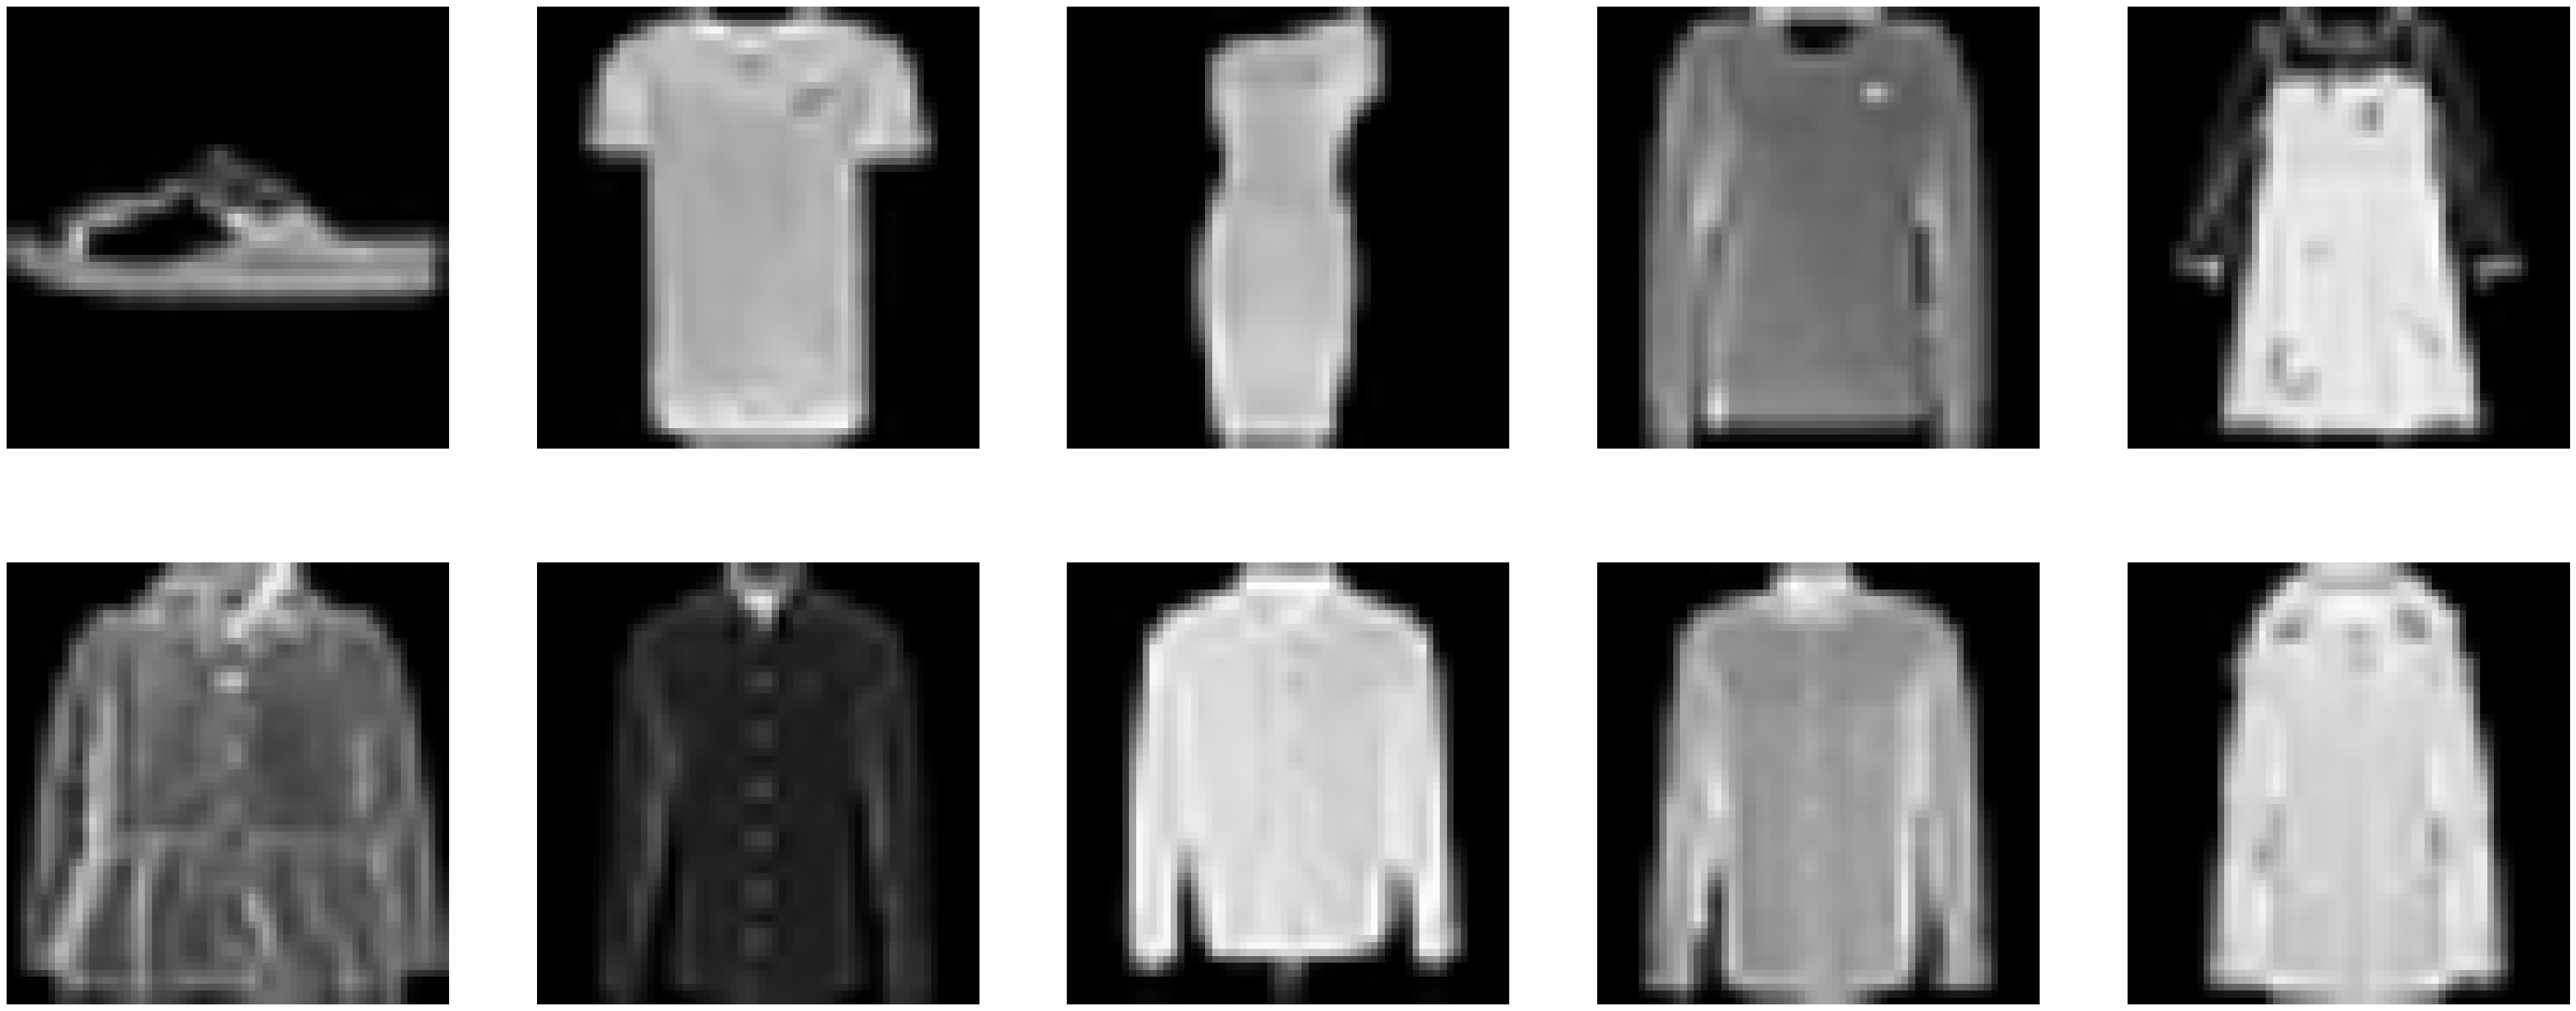

In [6]:
plot_images(test_ds)

 ### 📎Extract and Convert Images from Dataset to Numpy Arrays

In [7]:
X_train = []
X_test = []

for images, _ in train_ds:
    X_train.append(images.numpy())

for images, _ in test_ds:
    X_test.append(images.numpy())
    
X_train = np.concatenate(X_train, axis=0)
X_test = np.concatenate(X_test, axis=0)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (60000, 64, 64, 3)
X_test shape: (10000, 64, 64, 3)


> * **I Have ignored getting the labels**, as **Autoencoders** are based on **UnSupervised** learning principles

 ### Reshaping Image Data for Autoencoder Input


In [8]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*3)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2]*3)
X_train.shape

(60000, 12288)

 ### 📎Normalization

In [9]:
X_train.max()

255.0

In [10]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
X_train.max()

1.0

 # Autoencoder Model (AE)

> * **Autoencoders** are primarily used for **unsupervised learning**, allowing models to discover patterns and structures in unlabeled data. This capability makes them suitable for tasks like dimensionality reduction and feature extraction.
> 
> * There are **several types of autoencoders**, including **denoising autoencoders** (which learn to reconstruct corrupted inputs), **variational autoencoders** (which generate new data by learning a probabilistic representation), and ***convolutional autoencoders*** (which use convolutional layers for image data). Each variation has specific applications and benefits tailored to different data types and tasks.
> * **Here i will discuss Traditional Autoencoder and convolutional autoencoder**

In [12]:
input_shape = (X_train.shape[1],)  

input_layer = Input(shape=input_shape)  
bottleneck = Dense(32, activation='relu', name='bottleneck')(input_layer) #LATTEN REPRESENTATION
output = Dense(X_train.shape[1], activation='sigmoid', name='output')(bottleneck)

> 1. **Encoder**: This part of the network compresses the input data into a 
>    lower-dimensional representation, known as the bottleneck or latent space. 
>    The encoder captures the most important features of the input while discarding 
>    the less relevant information.

> 2. **Bottleneck**: The layer where the compressed representation is held. 
>    This layer contains fewer neurons than the input, forcing the model to learn 
>    a more abstract representation of the data.

> 3. **Decoder**: The decoder reconstructs the input data from the compressed 
>    representation. Its goal is to approximate the original input as closely as possible.

In [13]:
autoencoder = Model(input_layer, output)
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 32)             │       393,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12288)          │       405,504 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 798,752 (3.05 MB)

 Trainable params: 798,752 (3.05 MB)

 Non-trainable params: 0 (0.00 B)

> * **Input and Output Shape**: The input layer has a shape of (None, 12288), corresponding to flattened images (64x64x3). The output layer also has **the same shape**, indicating the model's goal is to reconstruct the original images.
> 
> * **Bottleneck Layer**: The bottleneck layer **reduces the dimensionality** to (None, 32), **capturing essential features** of the input data while discarding less important information. This compression helps the model learn efficient representations.

In [14]:
encoder = Model(input_layer, bottleneck)
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 32)             │       393,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393,248 (1.50 MB)

 Trainable params: 393,248 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
encoded_layer = Input(shape = (32,), name = 'encoded_layer')
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_layer, decoder_layer(encoded_layer))
decoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoded_layer (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12288)          │       405,504 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,504 (1.55 MB)

 Trainable params: 405,504 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

### Training the Model(Traditional Auto Encoder)

In [16]:
autoencoder.compile(loss='mse', optimizer='adam')

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,          
    restore_best_weights=True  
)

history = autoencoder.fit(
    X_train, X_train, 
    epochs=100, 
    batch_size=64, 
    validation_data=(X_test, X_test), 
    callbacks=[early_stopping] 
)


Epoch 1/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0412 - val_loss: 0.0178
Epoch 2/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0169 - val_loss: 0.0151
Epoch 3/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0147 - val_loss: 0.0150
Epoch 4/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0136 - val_loss: 0.0132
Epoch 5/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0128 - val_loss: 0.0136
Epoch 6/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0125 - val_loss: 0.0120
Epoch 7/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0121 - val_loss: 0.0119
Epoch 8/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0119 - val_loss: 0.0118
Epoch 9/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0118 - val_loss: 0.0118
Epoch 10/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0118 - val_loss: 0.0118
Epoch 11/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 12/100
938/938 ━━━━━━━━━━━━━━━━━━━━

### Plot training & validation loss values


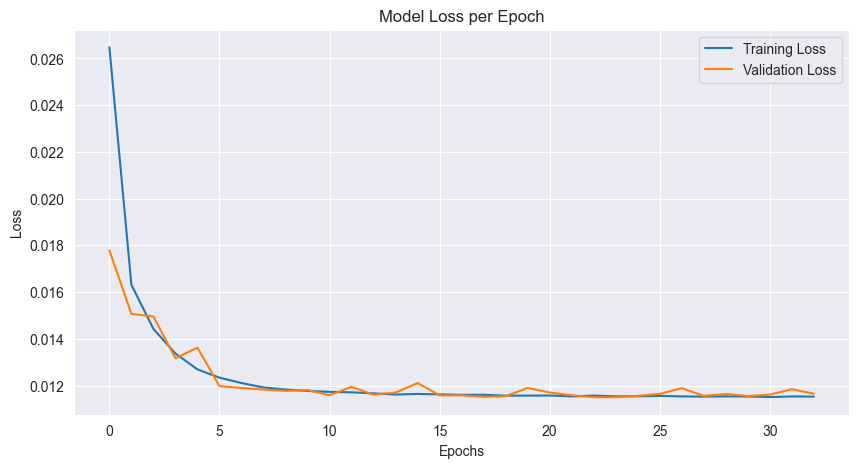

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.grid(True)  
plt.show()

### Encode test data

In [18]:
encoded_data = encoder.predict(X_test, batch_size=512)
encoded_data.shape

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


(10000, 32)

(10000, 32)
> * **10000** num of images in Test Data
> * **32** num of Neurons in Bottleneck

### 📎Decode test data

In [19]:
AE_data = decoder.predict(encoded_data, batch_size=512)
AE_data.shape

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


(10000, 12288)

In [20]:
AE_data = AE_data.reshape(AE_data.shape[0], 64,64,3)
AE_data.shape

(10000, 64, 64, 3)

In [21]:
X_test = X_test.reshape(10000, 64,64,3)
X_test.shape

(10000, 64, 64, 3)

> * AE_data has the smae shape as X_test
> * INPUT SHAPE = OUTPUT SHAEP

### 📎 Function to Visualize Original Images vs. Generated Images


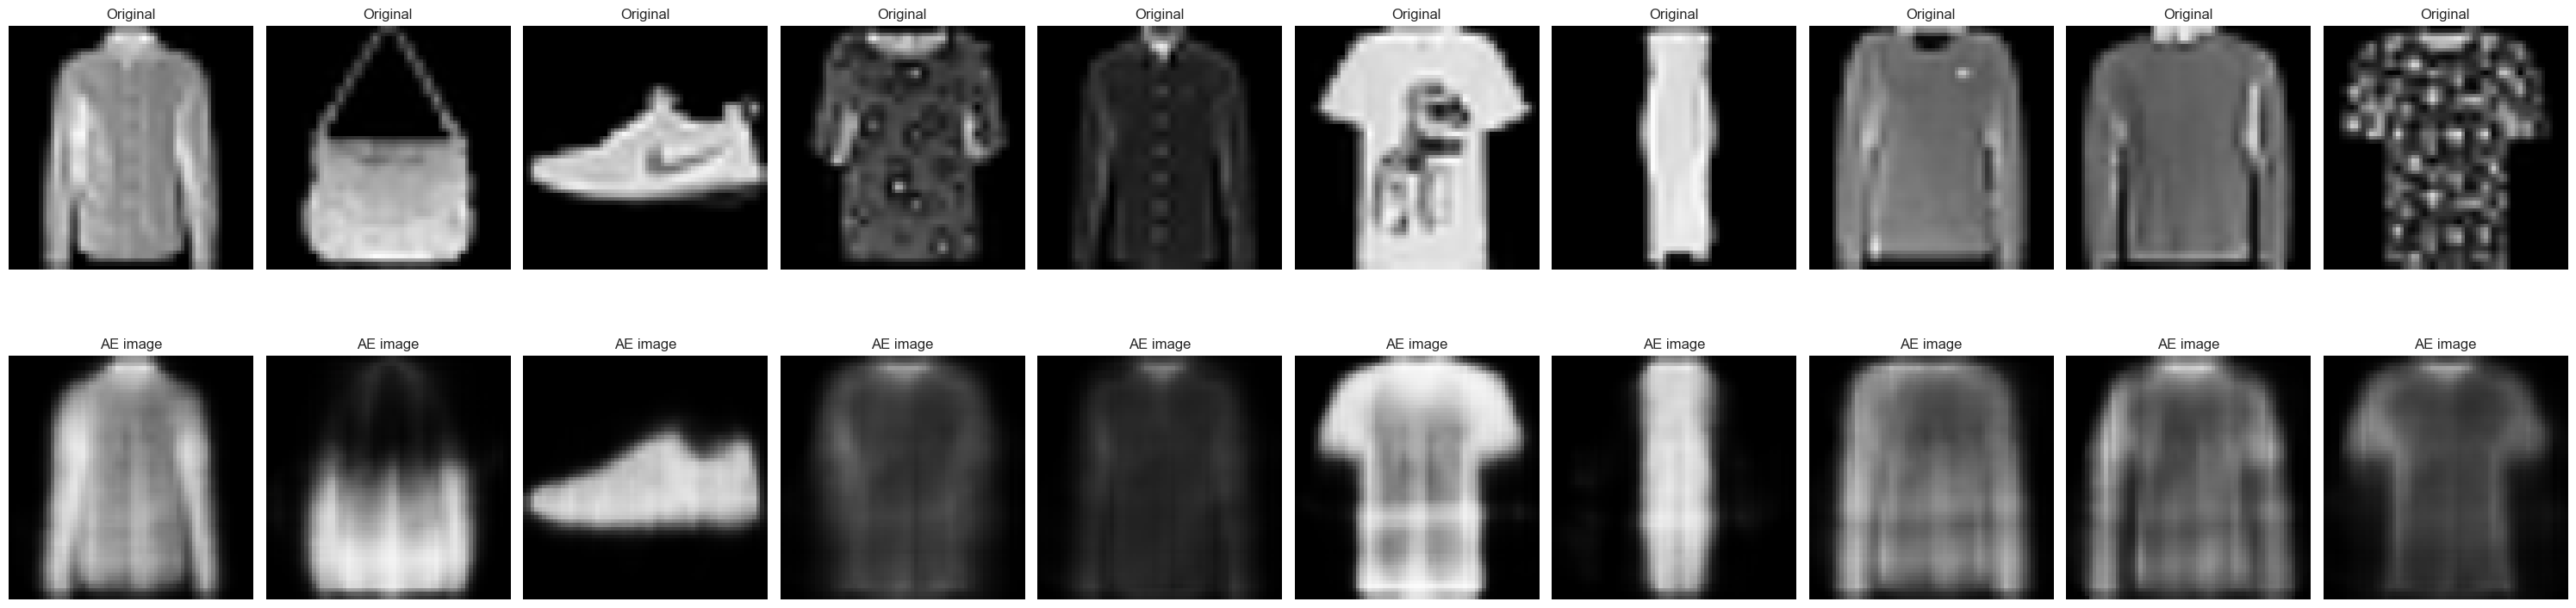

In [22]:
def compare_images(X_test, decoded_data,model, num_images=10):
 
    plt.figure(figsize=(30, 12))

    for i in range(num_images):
        # Original images
        plt.subplot(3, num_images, i + 1)
        plt.imshow(X_test[i])
        plt.axis('off')
        plt.title("Original")

        # Decoded images
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(decoded_data[i])
        plt.axis('off')
        plt.title(f"{model} image")

    plt.tight_layout()
    plt.show()

compare_images(X_test, AE_data,'AE', num_images=10)

### Reshaped Data to Convolution AutoEncoder

In [23]:
X_train.shape

(60000, 12288)

In [24]:
X_train = X_train.reshape(60000, 64,64,3)
X_train.shape

(60000, 64, 64, 3)

In [25]:
X_test.shape

(10000, 64, 64, 3)

# Convolution AutoEncoder (CAE)

> * **Input Layer**: Defines the shape of the input data (3 Channels).
> * **Encoder**:
> > Convolutional Layers: Extract features from the input data using filters.
> > Max Pooling Layers: Reduce the spatial dimensions of the feature maps to compress the representation.
> * **Decoder**:
> > Convolutional Layers: Start reconstructing the image from the encoded representation.
> > UpSampling Layers: Increase the spatial dimensions to restore the original image size.
> * **Output Layer**: Produces the final reconstructed image.

### Encoder

In [26]:
input_layer = Input(shape=(64, 64, 3))  

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPool2D(pool_size=(2, 2), padding='same')(x)


> * **The input layer**: of CAE initializes the model with **3 color channels** (RGB).


### Decoder

In [27]:
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x) 


In [28]:
autoencoder = Model(input_layer, decoded)
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 3)      │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,963 (19.39 KB)

 Trainable params: 4,963 (19.39 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
autoencoder.compile(loss = 'mse', optimizer = 'adam')

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,         
    restore_best_weights=True 
)

history = autoencoder.fit(
    X_train, 
    X_train, 
    epochs=100, 
    batch_size=128, 
    validation_data=(X_test, X_test), 
    callbacks=[early_stopping]  
)


Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 0.0416 - val_loss: 0.0077
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 0.0071 - val_loss: 0.0060
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 12/100
469/46

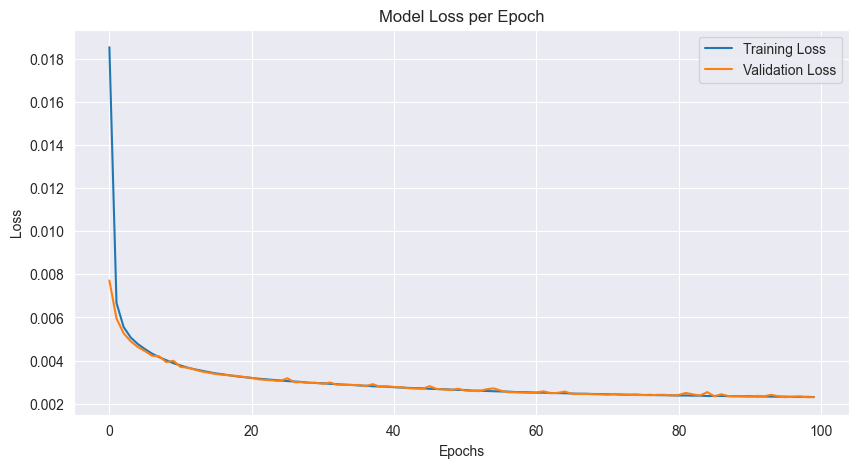

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.grid(True)  
plt.show()

In [31]:
# decoder_layer = Input(shape = (4,4,8))

# decoder = autoencoder.layers[7](decoder_layer)

# for layer in autoencoder.layers[8:]:
#     decoder = layer(decoder)

# decoder = Model(decoder_layer, decoder, name = 'Decoder')
# decoder.summary()

### 📎Encode test data

In [32]:
encoded_data = autoencoder.predict(X_test)
encoded_data.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


(10000, 64, 64, 3)

### 📎Decode test data

In [33]:
CAE_data = autoencoder.predict(encoded_data)
CAE_data.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


(10000, 64, 64, 3)

In [34]:
# # Encode the X_test data
# CAE_data  = autoencoder.predict(X_test)

# # Decode the encoded data (for visualization, if necessary)
# CAE_data  = autoencoder.predict(CAE_data )

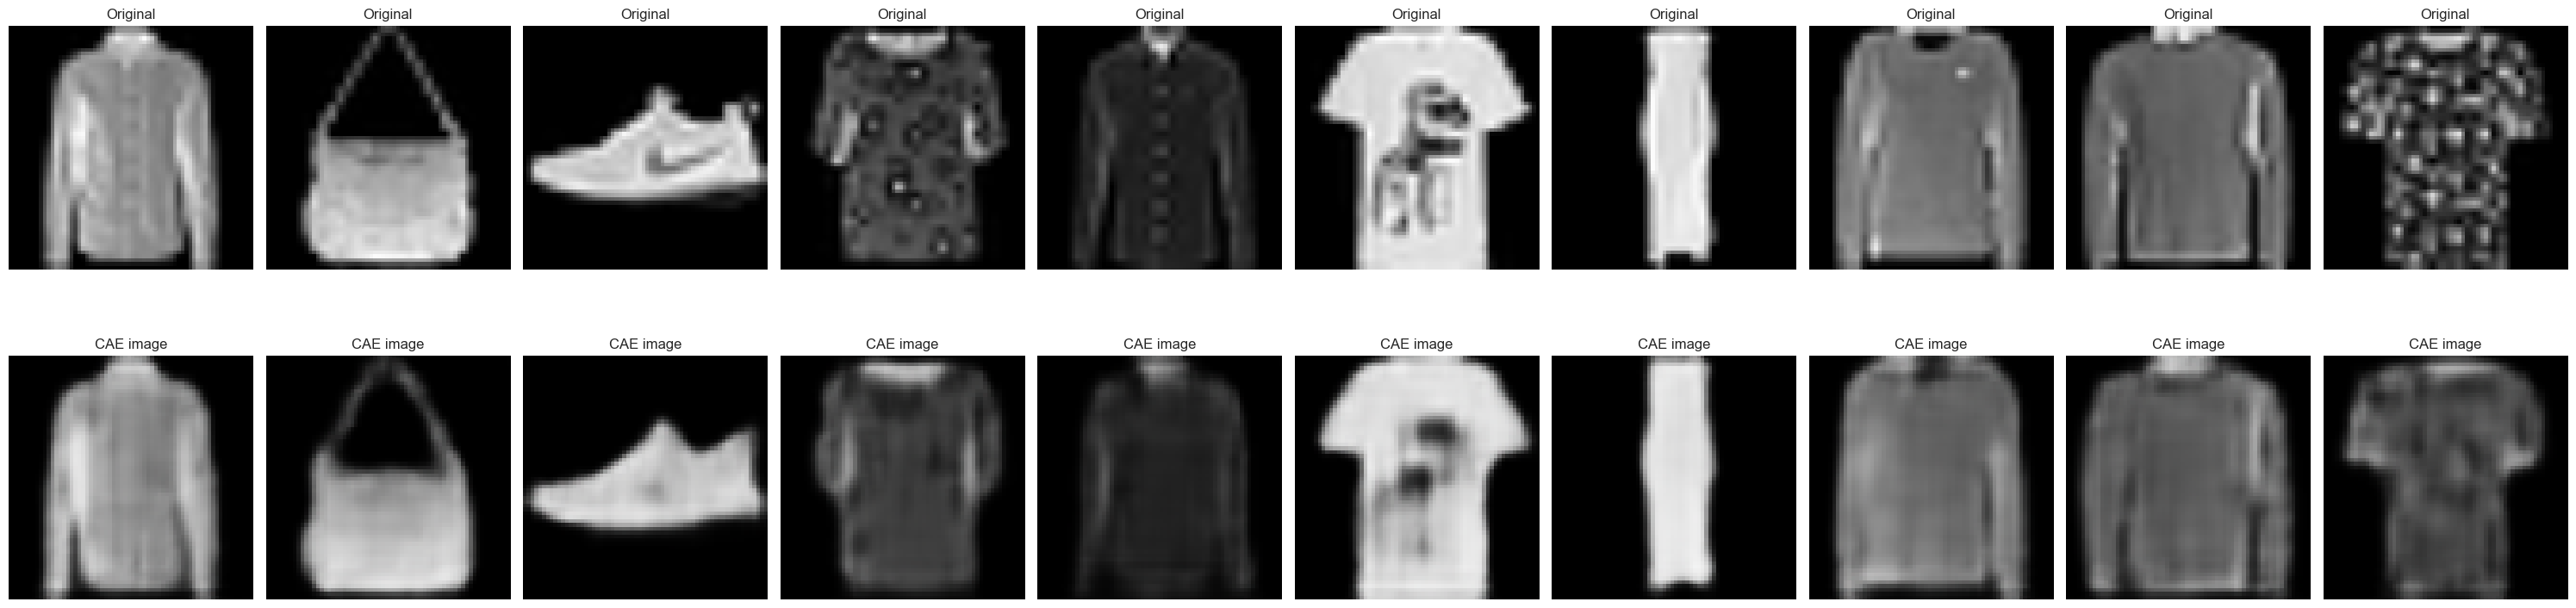

In [35]:
compare_images(X_test, CAE_data ,'CAE', num_images=10)

### 📎 Function to Visualize Original Images vs. Generated Images


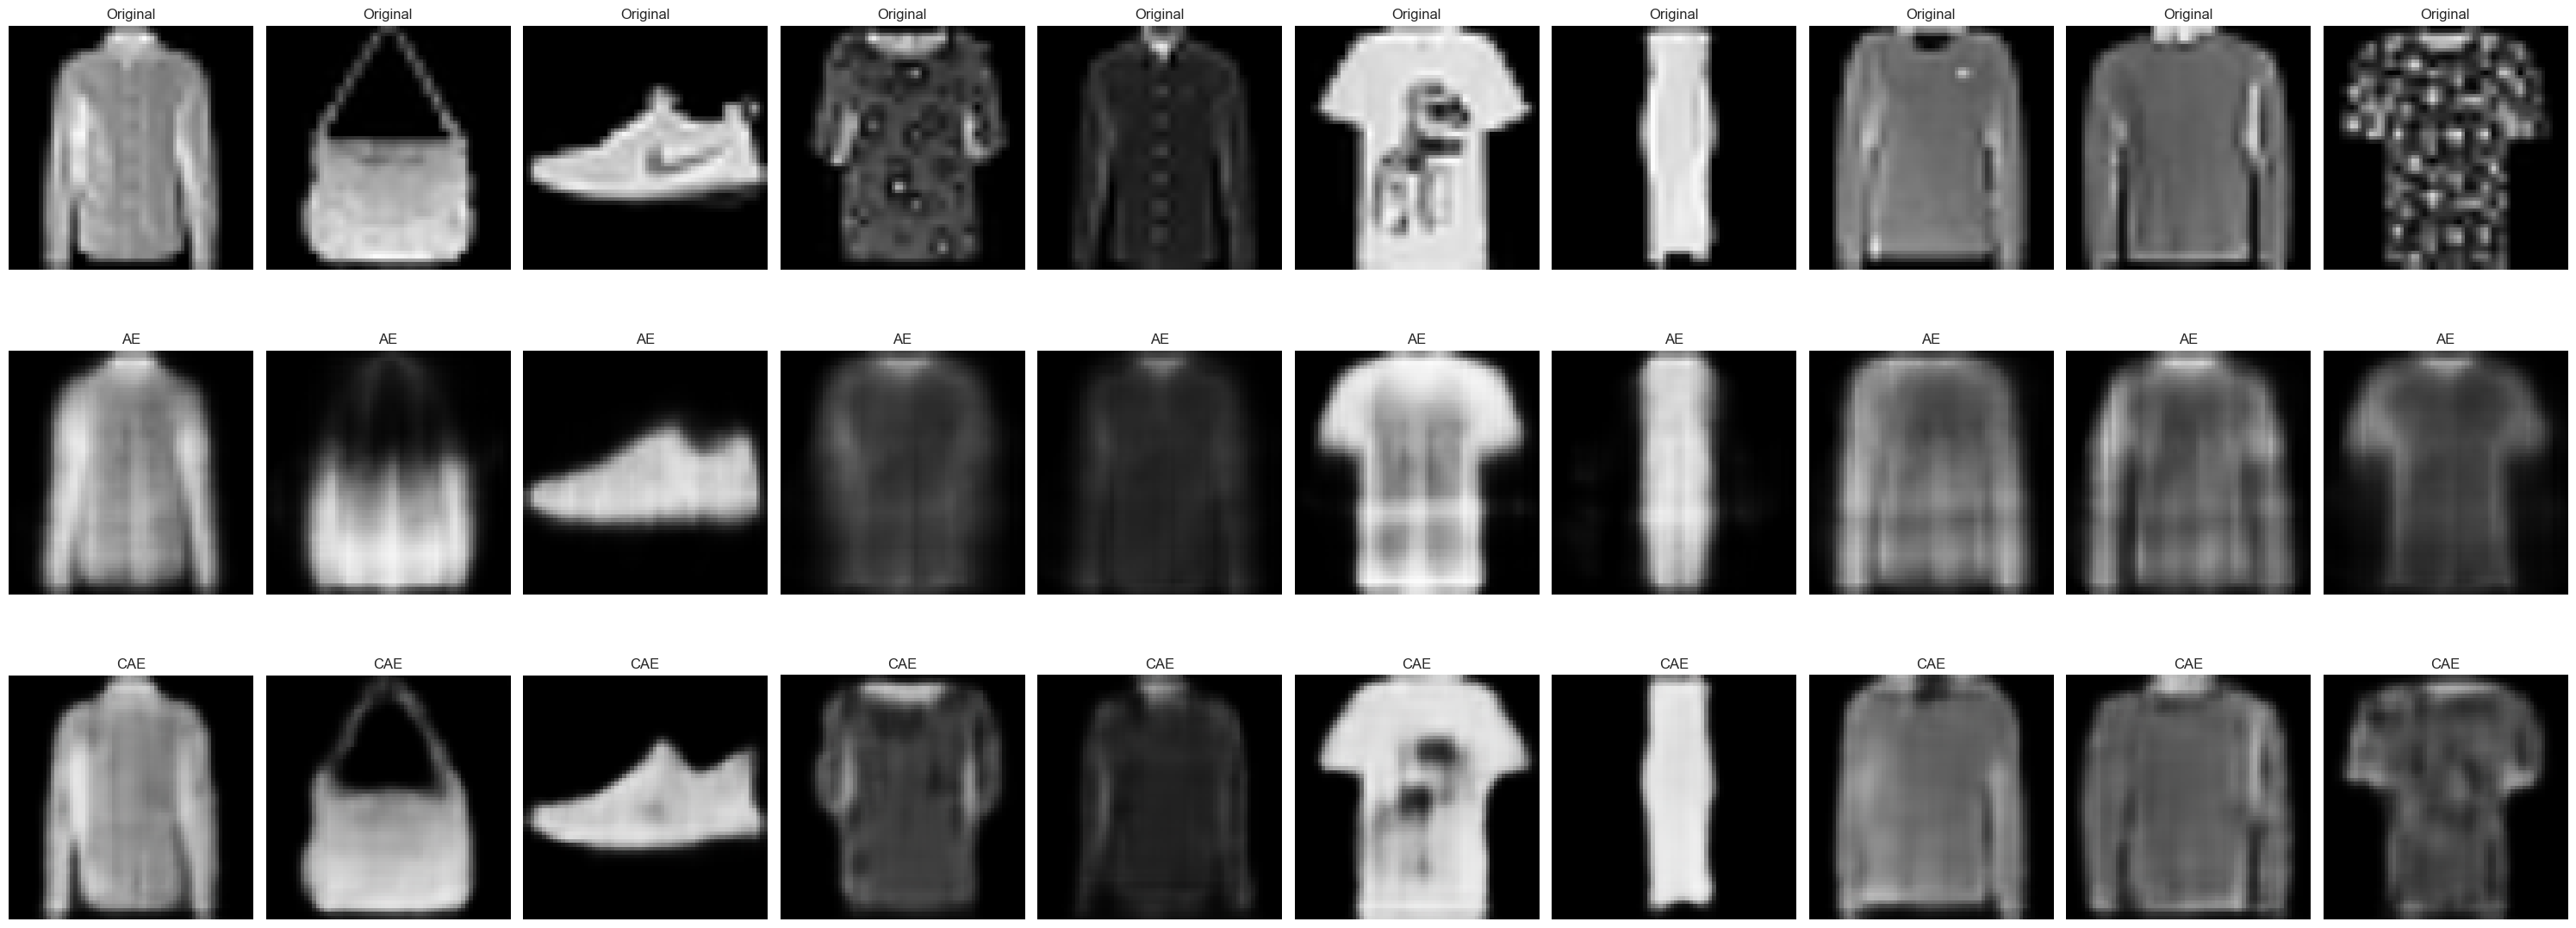

In [36]:
def compare_images_models(X_test, output_data, decoded_data, num_images=10):

    plt.figure(figsize=(30, 12))

    for i in range(num_images):
        # Original images
        plt.subplot(3, num_images, i + 1)
        plt.imshow(X_test[i])
        plt.axis('off')
        plt.title("Original")

        # TRADITIONAL AUTOENCODERS 
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(output_data[i])
        plt.axis('off')
        plt.title("AE")

        # CONVOLUTIONAL AUTOENCODERS
        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(decoded_data[i])
        plt.axis('off')
        plt.title("CAE")

    plt.tight_layout()
    plt.show()

compare_images_models(X_test, AE_data , CAE_data , num_images=10)
